In [1]:
import re
from io import StringIO

import pandas as pd
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration

MODEL = "Qwen/Qwen2.5-VL-7B-Instruct"  # 画像入力対応の公開重み

In [2]:
device_map = "auto"  # CUDA/MPS/CPU 自動
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

processor = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL, torch_dtype=torch_dtype, device_map=device_map, trust_remote_code=True
)
model.eval()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLU()

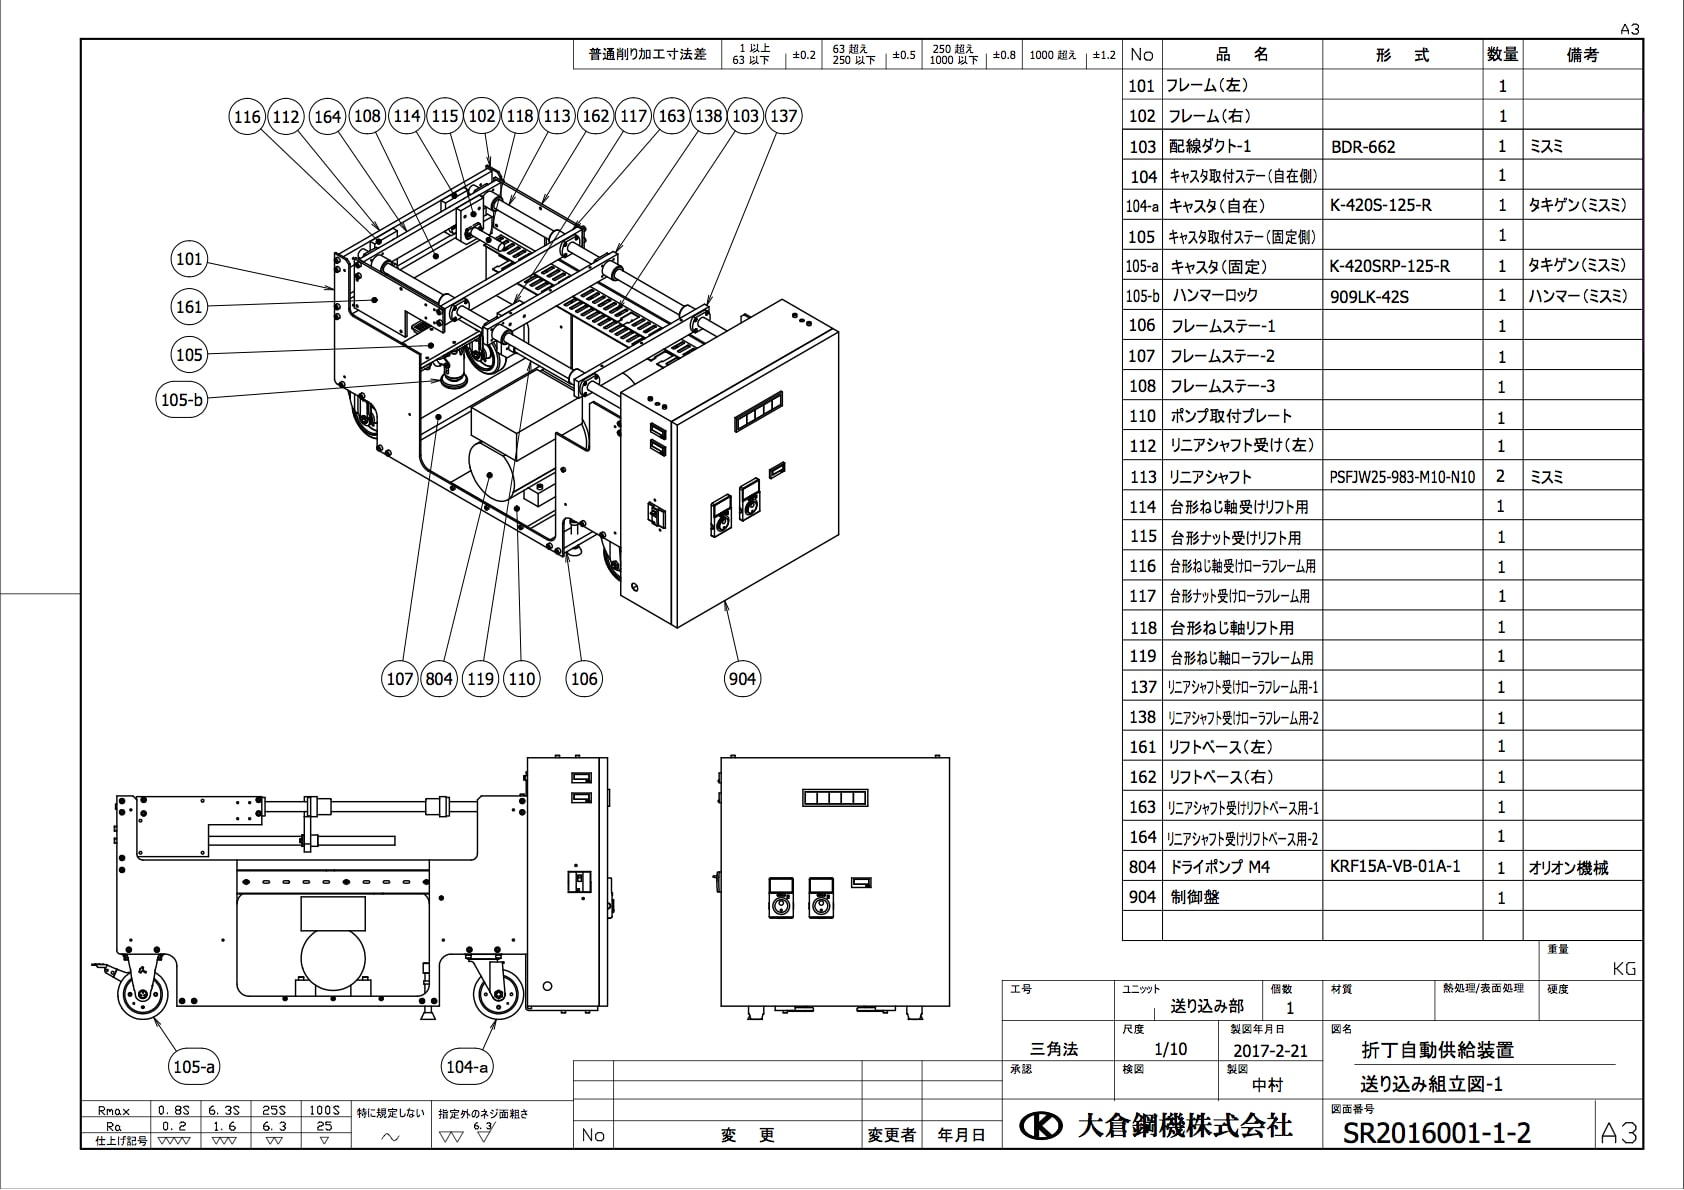

In [8]:
img = Image.open("./images/test.jpg").convert("RGB")
display(img)

In [9]:
prompt = (
    "あなたは、機械設計のスペシャリストです。"
    "この画像の中の**表**を抽出し、JSON schemaで厳密に出力しなさい。"
    "説明文・コードフェンスは禁止。先頭行はヘッダ。列数は各行で一致させること。"
    "空欄は''とし、英数字は半角とすること。"
)

In [10]:
# Qwenのチャットテンプレート：<image>トークンを含む形式
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": prompt},
        ],
    },
]
inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
).to(model.device)

with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=1200,
        do_sample=False,
        temperature=0,
    )

# Decode only the generated tokens (excluding the input)
generated_ids = [output_ids[i][len(inputs.input_ids[i]) :] for i in range(len(output_ids))]
text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


```json
[
    ["No", "品名", "形式", "数量", "備考"],
    ["101", "フレーム(左)", "", "1", ""],
    ["102", "フレーム(右)", "", "1", ""],
    ["103", "配線ダクト-1", "BDR-662", "1", "ミスミ"],
    ["104", "キャスタ取付ステー(自在側)", "", "1", ""],
    ["104-a", "キャスタ(自在)", "K-420S-125-R", "1", "タキゲン(ミスミ)"],
    ["105", "キャスタ取付ステー(固定側)", "", "1", ""],
    ["105-a", "キャスタ(固定)", "K-420SRP-125-R", "1", "タキゲン(ミスミ)"],
    ["105-b", "ハンマーロック", "909LK-42S", "1", "ハンマー(ミスミ)"],
    ["106", "フレームステー-1", "", "1", ""],
    ["107", "フレームステー-2", "", "1", ""],
    ["108", "フレームステー-3", "", "1", ""],
    ["110", "ポンプ取付プレート", "", "1", ""],
    ["112", "リニアシャフト受け(左)", "", "1", ""],
    ["113", "リニアシャフト", "PSFJW25-983-M10-N10", "2", "ミスミ"],
    ["114", "台形ねじ軸受けリフト用", "", "1", ""],
    ["115", "台形ナット受けリフト用", "", "1", ""],
    ["116", "台形ねじ軸受けローラフレーム用", "", "1", ""],
    ["117", "台形ナット受け軸リフト用", "", "1", ""],
    ["118", "台形ねじ軸ローラフレーム用", "", "1", ""],
    ["119", "台形ねじ軸ローラフレーム用", "", "1", ""],
    ["137", "リニアシャフト受けローラフレーム用-1", "", "1", ""],
   

In [6]:
# CSVだけを抽出
# Remove any leading text before the CSV data starts
lines = text.strip().split("\n")
csv_lines = []
csv_started = False

for line in lines:
    # Check if line looks like CSV (contains commas or is a header)
    if not csv_started and "," in line:
        csv_started = True
    if csv_started:
        # Skip code fence markers if present
        if not line.startswith("```"):
            csv_lines.append(line)

csv_text = "\n".join(csv_lines)

# 読めるか検証
try:
    if csv_text:
        df = pd.read_csv(StringIO(csv_text))
        print("Successfully parsed CSV:")
        print(df.head())
        print(f"\nShape: {df.shape}")
        df.to_csv("extracted_table.csv", index=False)
        print("Saved to extracted_table.csv")
    else:
        print("No CSV data found in the output")
        print("Raw output:", text[:1000])
except Exception as e:
    print(f"CSV parse failed: {e}")
    print("Raw CSV text:\n", csv_text[:1000])
    raise

Successfully parsed CSV:
                   No            品名  形式  数量   備考
101           フレーム(左)           NaN NaN NaN  1.0
102           フレーム(右)           NaN NaN NaN  1.0
103           配線ダクト-1       BDR-662 NaN NaN  1.0
104    キャスタ取付ステー(自在側)           NaN NaN NaN  1.0
104-a        キャスタ(自在)  K-420S-125-R NaN NaN  1.0

Shape: (28, 5)
Saved to extracted_table.csv
